In [1]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
from statsmodels.graphics.tsaplots import plot_acf

# Práctica 3: Prepocesamiento de Series de Tiempo

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones. Cada función está marcada por &#x1F625;,  &#x1F643; o &#x1F921;. Las marcas indican:

- &#x1F625;: Indican una entrega que debe ser hecha dentro de la misma sesión de la asignación. 
- &#x1F643;: Indican una entrega que puede ser hecha hasta la siguiente sesión.
- &#x1F921;: Debe mostrar un avance en la misma sesión, pero la entrega puede ser hecha en la siguiente.

Aquellas entregas parciales que no sean hechas el día de la asignación ya no serán válidas para las entregas totales, sin embargo, las entregas totales seguirán siendo válidas.

En esta sección se incluye una serie de tiempo real. El dataset importado incluye cuatro series de tiempo de la ciudad de Delhi, India, desde el 1 de enero de 2013 al 1 de enero de 2017 en muestreos diarios. Las series de tiempo incluidas son:

- __meantemp__: Temperatura promedio del día.
- __humidity__: Humedad promedio del día.
- __wind_speed__: Velocidad promedio del viento en el día.
- __meanpressure__: Presión promedio del día.

Este conjunto de datos no contiene datos nulos, por lo que no es necesario realizar una imputación dedatos.

In [3]:
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["date"] = pd.to_datetime(df["date"])
df.head(3)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.5,0.000000,1015.666667
1,2013-01-02,7.400000,92.0,2.980000,1017.800000
2,2013-01-03,7.166667,87.0,4.633333,1018.666667


## Asignación 1 &#x1F625;

La serie de tiempo __meanpressure__ contiene outliers. Analice la serie de tiempo y con base en su análisis, sustituya los outliers por valores válidos.

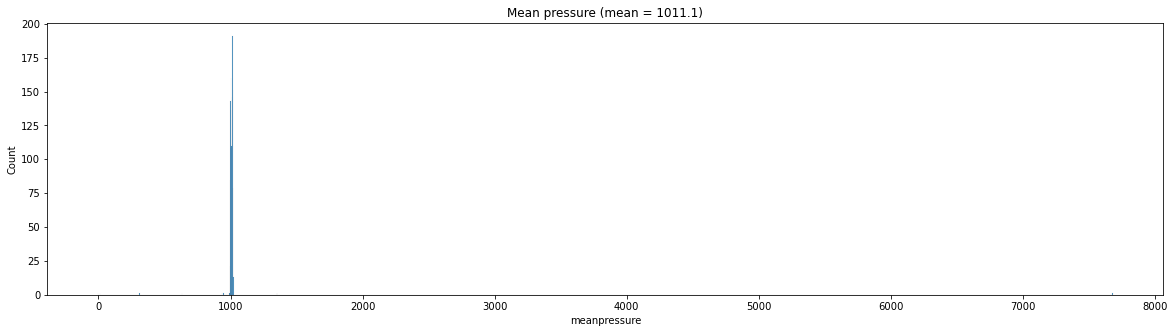

In [4]:
__fig__, __axs__ = plt.subplots(1, figsize=(20, 5))
__fig__.subplots_adjust(hspace=0.1, wspace=0.1)
__axs__.set(title="Mean pressure (mean = {})".format(round(df.meanpressure.mean(), 2)))
_ = sns.histplot(x=df.meanpressure, ax=__axs__)

In [5]:
np.max(np.array(df.meanpressure))

7679.333333333333

In [6]:
min_q = 0.01
max_q = 0.99
quant = df.meanpressure.quantile([min_q, max_q])
quant

0.01     994.201250
0.99    1021.131964
Name: meanpressure, dtype: float64

In [7]:
df.loc[df.meanpressure > quant[max_q], 'meanpressure']

18      1021.666667
21      1021.800000
357     1021.375000
383     1023.000000
384     1021.375000
716     1021.375000
717     1022.125000
722     1021.250000
764     1022.000000
1087    1021.250000
1088    1022.000000
1095    1021.142857
1182    7679.333333
1362    1352.615385
1416    1350.296296
Name: meanpressure, dtype: float64

In [8]:
df.loc[df.meanpressure > quant[max_q], 'meanpressure'] = quant[max_q]

In [9]:
df.loc[df.meanpressure < quant[min_q], 'meanpressure']

215     993.250000
522     994.000000
523     993.125000
524     993.125000
532     994.125000
534     993.250000
535     991.375000
536     993.875000
925     993.750000
1255    938.066667
1300    946.312500
1309    310.437500
1321    633.900000
1323     -3.041667
1427     12.045455
Name: meanpressure, dtype: float64

In [10]:
df.loc[df.meanpressure < quant[min_q], 'meanpressure'] = quant[min_q]

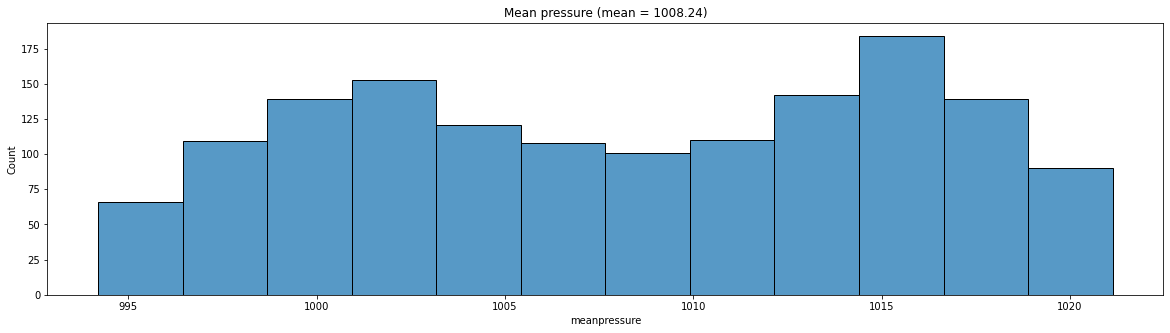

In [11]:
__fig__, __axs__ = plt.subplots(1, figsize=(20, 5))
__fig__.subplots_adjust(hspace=0.1, wspace=0.1)
__axs__.set(title="Mean pressure (mean = {})".format(round(df.meanpressure.mean(), 2)))
_ = sns.histplot(x=df.meanpressure, ax=__axs__)

## Asignación 2 &#x1F625;

Normalice todas las series de tiempo para que tengan media cero y varianza 1.  Imprima la descripción del dataframe para validar.

In [12]:
def normalize_cols(cols):
    return (cols - cols.mean()) / cols.std()

In [13]:
def normalize_data(data, exceptions = None):
    data_columns = data.columns
    for col_name in data_columns:
        if col_name not in exceptions:
            new_value = normalize_cols(data[col_name])
            data[col_name] = new_value
    return data

In [14]:
normalized_df = normalize_data(df, ['date'])

In [15]:
normalized_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,-2.108778,1.414955,-1.491189,0.993995
1,2013-01-02,-2.462611,1.862191,-0.837909,1.279465
2,2013-01-03,-2.494366,1.564034,-0.475464,1.395437
3,2013-01-04,-2.290231,0.629806,-1.220816,1.194716
4,2013-01-05,-2.653137,1.554095,-0.680070,1.105507
...,...,...,...,...,...
1457,2016-12-28,-1.126567,0.433627,-0.713430,0.980420
1458,2016-12-29,-1.395928,1.615146,-0.175861,1.159670
1459,2016-12-30,-1.551459,1.723051,-0.117402,1.293483
1460,2016-12-31,-1.421168,1.564034,0.114607,1.051981


## Asignación 3 &#x1F625;

Entrene una regresión lineal para predecir el valor de __meantemp__ utilizando las series de tiempo __humidity__, __wind_speed__ y __meanpressure__. Use la función _numpy.linalg.lstsq_ para esto. Una vez entrenada la regresión, grafique la serie de tiempo __meantemp__ junto con la serie de tiempo de las predicciones del modelo.

In [16]:
X = normalized_df[['humidity', 'wind_speed', 'meanpressure']].to_numpy()
y = normalized_df['meantemp'].to_numpy()
y = np.array([[i] for i in y])

In [17]:
def add_bias_col(X):
    return np.insert(X, 0, 1, axis = 1)

In [18]:
m, c = np.linalg.lstsq(add_bias_col(X), y, rcond=None)[0:2]

In [19]:
pred = add_bias_col(X) @ m

In [20]:
df['pred'] = pred

In [21]:
df

,date,meantemp,humidity,wind_speed,meanpressure,pred
0,2013-01-01,-2.108778,1.414955,-1.491189,0.993995,-1.178813
1,2013-01-02,-2.462611,1.862191,-0.837909,1.279465,-1.580542
2,2013-01-03,-2.494366,1.564034,-0.475464,1.395437,-1.587124
3,2013-01-04,-2.290231,0.629806,-1.220816,1.194716,-1.083555
4,2013-01-05,-2.653137,1.554095,-0.680070,1.105507,-1.349227
...,...,...,...,...,...,...
1457,2016-12-28,-1.126567,0.433627,-0.713430,0.980420,-0.874459
1458,2016-12-29,-1.395928,1.615146,-0.175861,1.159670,-1.434849
1459,2016-12-30,-1.551459,1.723051,-0.117402,1.293483,-1.577681
1460,2016-12-31,-1.421168,1.564034,0.114607,1.051981,-1.347331


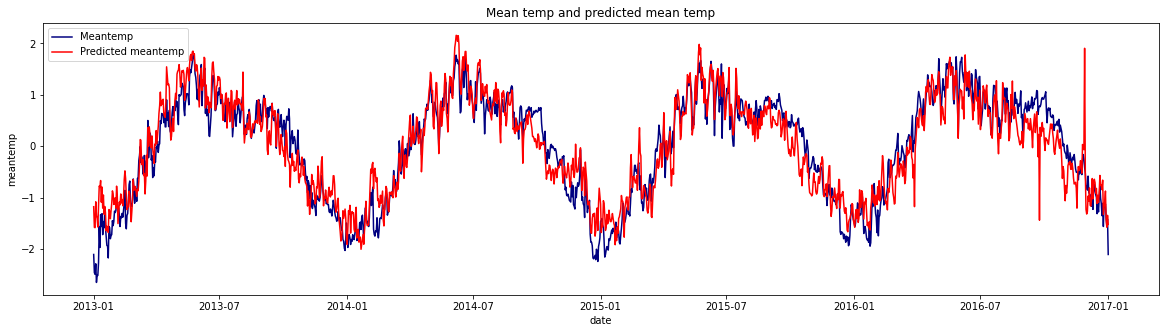

In [22]:
__fig__, __axs__ = plt.subplots(nrows=1, figsize=(20, 5))
__fig__.subplots_adjust(hspace=0.5, wspace=0.1)
__axs__.set(title="Mean temp and predicted mean temp")
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.meantemp, ax=__axs__, label = 'Meantemp', color = 'navy')
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.pred, ax=__axs__, label = 'Predicted meantemp', color = 'red')

## Asignación 4 &#x1F643;

La serie de tiempo __meantemp__ presenta ciclos por temporadas y una ligera tendencia creciente. Entrene una regresión lineal donde las variables independientes estén en función del tiempo que permita replicar estas tendencias. En una sola gráfica imprima la serie de tiempo __meantemp__, la gráfica de la tendencia (predicciones del modelo) y la gráfica sin tendencia, es decir, la resta de la serie de tiempo __meantemp__ y las predicciones del modelo (residuales).

Nota: Utilice una frecuencia fija de $1/365$ para replicar los ciclos.

In [23]:
times = np.array([i for i in range(len(df))])

In [24]:
len(times)

1462

In [25]:
def generate_cols_signal(w, times):
    cosines = np.cos(2 * np.pi * w * times)
    sines = np.sin(2 * np.pi * w * times)
    X = np.array([[1, cosines[i], sines[i], times[i]] for i in range(len(cosines))])
    
    return X

In [26]:
w = 1 / 365

In [27]:
meantemp = np.array([[i] for i in list(normalized_df.meantemp)])

In [28]:
X_signal = generate_cols_signal(w, times)

In [29]:
m, c = np.linalg.lstsq(X_signal, meantemp, rcond=None)[0:2]

In [30]:
pred_signal = X_signal @ m

In [31]:
df['pred_signal'] = pred_signal

In [32]:
df

,date,meantemp,humidity,wind_speed,meanpressure,pred,pred_signal
0,2013-01-01,-2.108778,1.414955,-1.491189,0.993995,-1.178813,-1.480774
1,2013-01-02,-2.462611,1.862191,-0.837909,1.279465,-1.580542,-1.481324
2,2013-01-03,-2.494366,1.564034,-0.475464,1.395437,-1.587124,-1.481497
3,2013-01-04,-2.290231,0.629806,-1.220816,1.194716,-1.083555,-1.481294
4,2013-01-05,-2.653137,1.554095,-0.680070,1.105507,-1.349227,-1.480715
...,...,...,...,...,...,...,...
1457,2016-12-28,-1.126567,0.433627,-0.713430,0.980420,-0.874459,-1.049008
1458,2016-12-29,-1.395928,1.615146,-0.175861,1.159670,-1.434849,-1.050684
1459,2016-12-30,-1.551459,1.723051,-0.117402,1.293483,-1.577681,-1.051985
1460,2016-12-31,-1.421168,1.564034,0.114607,1.051981,-1.347331,-1.052910


In [33]:
normalized_df['detrended_meantemp'] = normalized_df['meantemp'] - normalized_df['pred_signal']

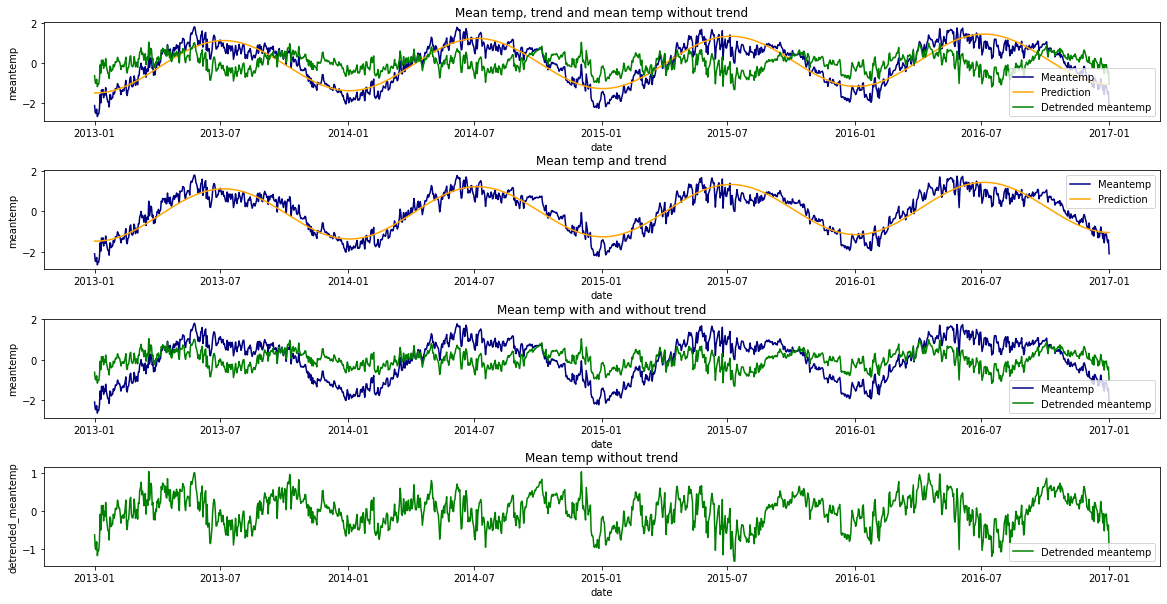

In [34]:
__fig__, __axs__ = plt.subplots(nrows=4, figsize=(20, 10))
__fig__.subplots_adjust(hspace=0.5, wspace=0.1)
__axs__[0].set(title="Mean temp, trend and mean temp without trend")
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.meantemp, ax=__axs__[0], label = 'Meantemp', color = 'navy')
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.pred_signal, ax=__axs__[0], label = 'Prediction', color = 'orange')
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.detrended_meantemp, ax=__axs__[0], label = 'Detrended meantemp', color = 'green')
__axs__[1].set(title="Mean temp and trend")
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.meantemp, ax=__axs__[1], label = 'Meantemp', color = 'navy')
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.pred_signal, ax=__axs__[1], label = 'Prediction', color = 'orange')
__axs__[2].set(title="Mean temp with and without trend")
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.meantemp, ax=__axs__[2], label = 'Meantemp', color = 'navy')
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.detrended_meantemp, ax=__axs__[2], label = 'Detrended meantemp', color = 'green')
__axs__[3].set(title="Mean temp without trend")
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.detrended_meantemp, ax=__axs__[3], label = 'Detrended meantemp', color = 'green')

## Asignación 5 &#x1F643;

Elimine las tendencias de la serie de tiempo __meantemp__ utilizando diferencias de primero orden. Debe realizar dos diferencias, una para eliminar la tendencia creciente y otra para eliminar los ciclos por temporadas. Grafique la serie de tiempo de __meantemp__ junto con la serie de tiempo estacionaria.

In [35]:
def diffs_trends(serie, diff_type):
    for t in diff_type:
        if t == 'inc':
            serie = serie.diff()
        elif t == 'cyc':
            serie = serie.diff(periods = 365)
    return serie

In [36]:
diff_type = ['inc', 'cyc']

In [37]:
meantemp_st = np.array(diffs_trends(df.meantemp, diff_type))

In [38]:
normalized_df['meantemp_st'] = meantemp_st

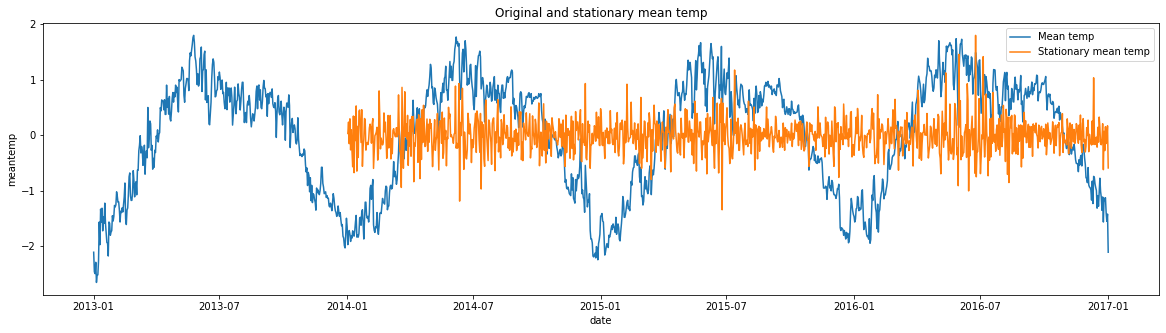

In [39]:
__fig__, __axs__ = plt.subplots(nrows=1, figsize=(20, 5))
__fig__.subplots_adjust(hspace=0.5, wspace=0.1)
__axs__.set(title="Original and stationary mean temp")
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.meantemp, ax=__axs__, label = 'Mean temp')
_ = sns.lineplot(x=normalized_df.date, y=normalized_df.meantemp_st, ax=__axs__, label = 'Stationary mean temp')

## Asignación 6 &#x1F643;

Grafique el correlograma de la serie de tiempo __meantemp__ y el correlograma de __meantemp__ diferenciada (estacionaria). Utilice la función _plot_acf_ para graficar el correlograma.

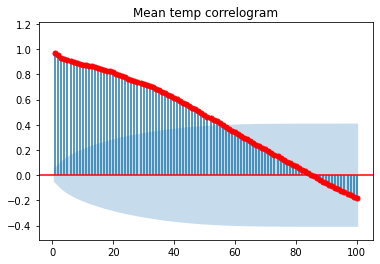

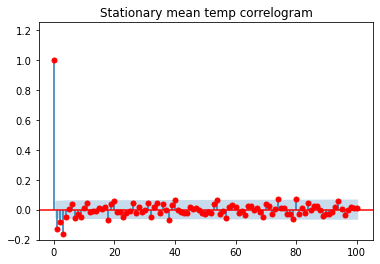

In [41]:
plot_acf(normalized_df.meantemp, lags=100, alpha=0.05, zero = False, title = 'Mean temp correlogram', color="red", auto_ylims = True)
plot_acf(normalized_df.meantemp_st.dropna(), lags=100, alpha=0.05, zero = True, title = 'Stationary mean temp correlogram', color="red", auto_ylims = True)
plt.show()